In [1]:
import librosa
import matplotlib.pyplot as plt


def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original Signal")
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Augmented Signal")
    plt.show()


In [1]:
import os
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pickle
from collections import Counter
from pydub import AudioSegment
import wave
import math
import uuid

2024-05-05 15:43:01.290278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 15:43:01.360161: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 15:43:01.363434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-05 15:43:01.363444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
# Define raw audio dictionary
raw_audio = {}

# Loop through directioris and label audio files
directories = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']
for directory in directories:
    path = '../data/raw2/' + directory
    for filename in os.listdir(path):
        if filename.endswith(".wav"):
            raw_audio[os.path.join(path, filename)] = directory

In [131]:

import numpy as np

# Define a fixed length for MFCC feature vectors
max_length = 100

# Extract MFCC Features and Chop audio
# Preemphasis filter for high frequency
def preemphasis_filter(signal, alpha=0.97):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

# Frame the signal into 25 ms frame and 10 ms frame shift
def frame_signal(signal, frame_length, frame_shift):
    num_samples = len(signal)
    num_frames = 1 + int(np.ceil((num_samples - frame_length) / frame_shift))
    frames = np.zeros((num_frames, frame_length))
    for i in range(num_frames):
        start = i * frame_shift
        end = min(start + frame_length, num_samples)  # Ensure end does not exceed num_samples
        frames[i, :end-start] = signal[start:end] * np.hamming(end-start)
    return frames

# Compute for power spectrum
def power_spectrum(frames):
    return np.abs(np.fft.rfft(frames, axis=1))**2 / frames.shape[1]

# Apply Mel Filterbank
def mel_filterbank(spectrum, num_filters=40, sampling_rate=22050, n_fft=512):
    mel_filterbank = librosa.filters.mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_filters)
    return np.dot(mel_filterbank, spectrum)

# Compute MFCCS
def mfcc(signal, sampling_rate=22050, frame_length=512, frame_shift=256, num_mfcc=13):
    emphasized_signal = preemphasis_filter(signal)
    framed_signal = frame_signal(emphasized_signal, frame_length, frame_shift)
    spectrum = power_spectrum(framed_signal)
    mel_spectrum = mel_filterbank(spectrum.T, num_filters=num_mfcc, sampling_rate=sampling_rate)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrum), n_mfcc=num_mfcc)
    
    if mfccs.shape[1] < max_length:
        mfccs_padded = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > max_length:
        mfccs_padded = mfccs[:, :max_length]
    else:
        mfccs_padded = mfccs
    
    return mfccs_padded


In [132]:
'''
# Extract MFCC Features and create DataFrame
X = []
y = []

for audio_file, label in raw_audio.items():
    signal, sr = librosa.load(audio_file, sr=None)
    mfcc_features = mfcc(signal, sampling_rate=sr)
    X.append(mfcc_features.flatten())
    y.append(label)

df = pd.DataFrame(X)
df = df.fillna(0)
df['label'] = y

df.to_csv('audio_dataset.csv', index=False)
'''

In [3]:
# Define function to extract MFCC features and chop audio
def extract_mfcc(audio_file, max_length=100):
    audiofile, sr = librosa.load(audio_file)
    fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=20)
    if fingerprint.shape[1] < max_length:
        pad_width = max_length - fingerprint.shape[1]
        fingerprint_padded = np.pad(fingerprint, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return fingerprint_padded.T
    elif fingerprint.shape[1] > max_length:
        return fingerprint[:, :max_length].T
    else:
        return fingerprint.T


# Chop audio and extract MFCC features for each track
X = []
y = []
max_length = 100

for i, (audio_file, label) in enumerate(raw_audio.items()):
    mfcc_features = extract_mfcc(audio_file, max_length=max_length)
    X.append(mfcc_features.flatten())
    y.append(label)

 # Convert features and labels to DataFrame and save to CSV
df = pd.DataFrame(X)
df = df.fillna(0)
df['label'] = y
df.to_csv('audio_dataset.csv', index=False)

In [4]:
X = np.array(X)
y = np.array(y)

X_flat = X.reshape(X.shape[0], -1)
y_flat = y

# Split the dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

In [5]:
models = [("Random Forest", RandomForestClassifier()), 
          ("Logistic Regression", LogisticRegression()), 
          ("SVM", SVC()), 
          ("Decision Tree", DecisionTreeClassifier())]

In [6]:


print("Model, Accuracy, Precision, Recall")
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"{model_name}: {accuracy}, {precision}, {recall}")



Model, Accuracy, Precision, Recall


/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest: 0.782608695652174, 0.6124763705103969, 0.782608695652174


/home/kotaro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression: 0.7065217391304348, 0.6055900621118012, 0.7065217391304348
SVM: 0.782608695652174, 0.6124763705103969, 0.782608695652174
Decision Tree: 0.6630434782608695, 0.6281464530892449, 0.6630434782608695


In [7]:
X_train.shape

(273, 2000)

In [8]:
# Reshape data for LSTM input
n_samples, n_features = X_train.shape[0], X_train.shape[1] // 100
n_timesteps = 100
X_train_lstm = X_train.reshape((n_samples, 100, 20))
n_samples_test = X_test.shape[0]
X_test_lstm = X_test.reshape((n_samples_test, n_timesteps, n_features))

# Convert labels to numeric values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define LSTM model
lstm_model = Sequential([
    LSTM(units=128, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(units=64, activation='relu'),
    Dropout(0.2),
    Dense(units=len(np.unique(y_train_encoded)), activation='softmax')
])


# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate LSTM model
_, accuracy = lstm_model.evaluate(X_test_lstm, y_test_encoded)
print("Accuracy:", accuracy)

from sklearn.metrics import precision_score, recall_score

# Predict probabilities for the test dataset using the trained LSTM model
predicted_probabilities = lstm_model.predict(X_test_lstm)

# Convert probabilities to class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Calculate precision
precision = precision_score(y_test_encoded, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(y_test_encoded, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)


2024-05-05 15:43:50.601527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-05 15:43:50.601683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-05 15:43:50.601712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-05-05 15:43:50.601733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-05-05 15:43:50.601753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/10
7/7 [==============================] - 1s 77ms/step - loss: 1.5484 - accuracy: 0.3761 - val_loss: 0.7251 - val_accuracy: 0.9455
Epoch 2/10
7/7 [==============================] - 0s 43ms/step - loss: 0.8270 - accuracy: 0.8073 - val_loss: 0.3287 - val_accuracy: 0.9455
Epoch 3/10
7/7 [==============================] - 0s 44ms/step - loss: 0.7384 - accuracy: 0.8394 - val_loss: 0.2859 - val_accuracy: 0.9455
Epoch 4/10
7/7 [==============================] - 0s 41ms/step - loss: 0.6440 - accuracy: 0.8394 - val_loss: 0.2977 - val_accuracy: 0.9455
Epoch 5/10
7/7 [==============================] - 0s 44ms/step - loss: 0.6633 - accuracy: 0.8394 - val_loss: 0.3194 - val_accuracy: 0.9455
Epoch 6/10
7/7 [==============================] - 0s 44ms/step - loss: 0.6418 - accuracy: 0.8394 - val_loss: 0.3397 - val_accuracy: 0.9455
Epoch 7/10
7/7 [==============================] - 0s 45ms/step - loss: 0.6307 - accuracy: 0.8394 - val_loss: 0.3367 - val_accuracy: 0.9455
Epoch 8/10
7/7 [===========

/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import joblib

# Save the model
joblib.dump(lstm_model, "lstm_audio_model.joblib")


INFO:tensorflow:Assets written to: ram://c1573b7d-3ac6-440e-85df-db632ae03224/assets


INFO:tensorflow:Assets written to: ram://c1573b7d-3ac6-440e-85df-db632ae03224/assets


['lstm_audio_model.joblib']

In [10]:


def pickle_model(model, modelname):
    directory = 'models'
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(os.path.join(directory, str(modelname) + '.pkl'), 'wb') as f:
        return pickle.dump(model, f)

model = SVC()
model.fit(X_train, y_train)
pickle_model(model, "mySVC")



In [11]:
def getModel(pickle_path):
  with open(pickle_path, 'rb') as f:
        return pickle.load(f)


In [12]:
predictions = []

folder_path = '../data/samples/'

for filename in os.listdir(folder_path):
    if filename.endswith(".wav"):
        try:
            audiofile, sr = librosa.load(os.path.join(folder_path, filename))
            fingerprint = librosa.feature.mfcc(y=audiofile, sr=sr, n_mfcc=20)
            fingerprint_flat = fingerprint.reshape(-1)  # Flatten the MFCC features
            # Pad or truncate features to match the number of features used for training
            if len(fingerprint_flat) < 2000:
                fingerprint_flat = np.pad(fingerprint_flat, (0, 2000 - len(fingerprint_flat)))
            elif len(fingerprint_flat) > 2000:
                fingerprint_flat = fingerprint_flat[:2000]
            prediction = model.predict([fingerprint_flat])  # Reshape to match expected input format
            predictions.append(prediction[0])
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

from collections import Counter
data = Counter(predictions)
print(data)  # Returns all unique items and their counts


Counter({'hungry': 24})


/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set t

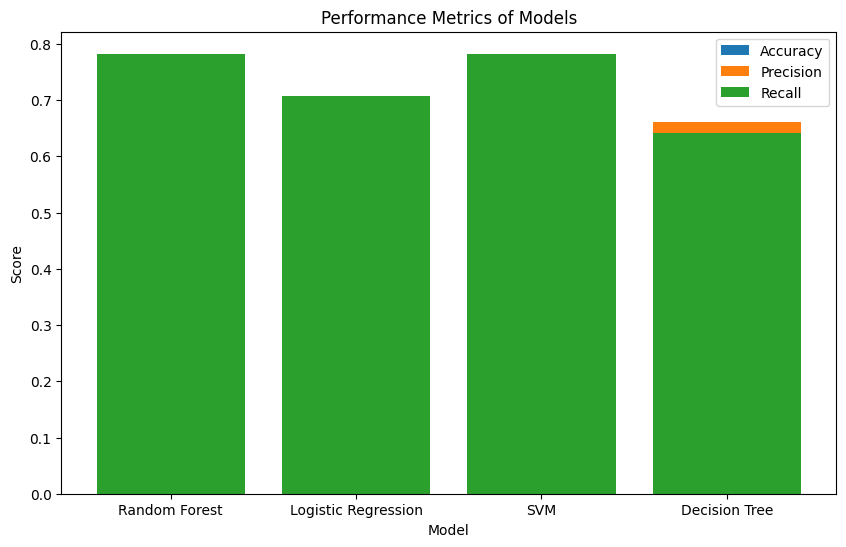

In [13]:
import matplotlib.pyplot as plt

# Lists to store metrics for each model
model_names = []
accuracies = []
precisions = []
recalls = []

# Loop through models and calculate metrics
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Append metrics to lists
    model_names.append(model_name)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Plot metrics
plt.figure(figsize=(10, 6))

plt.bar(model_names, accuracies, label='Accuracy')
plt.bar(model_names, precisions, label='Precision')
plt.bar(model_names, recalls, label='Recall')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics of Models')
plt.legend()

plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming you already have your X and y (features and labels)

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define models
models = [
    ("Random Forest", RandomForestClassifier()),
    ("SVM", SVC()),
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier())
]

# Step 3: Train and evaluate each model
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Print the evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kotaro/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Random Forest
Accuracy: 0.782608695652174
Precision: 0.6124763705103969
Recall: 0.782608695652174
Model: SVM
Accuracy: 0.782608695652174
Precision: 0.6124763705103969
Recall: 0.782608695652174


/home/kotaro/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.6630434782608695
Precision: 0.6346739130434783
Recall: 0.6630434782608695
Model: Decision Tree
Accuracy: 0.6956521739130435
Precision: 0.7181001890359168
Recall: 0.6956521739130435
